# **Importing necessary libraries**

In [ ]:
import nltk
nltk.download('book')

In [ ]:
import numpy as np
from nltk.tokenize import word_tokenize
import pandas as pd
import tensorflow as tf
import operator
import gensim
import string
import re
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional,Concatenate
from keras.layers import TimeDistributed
from keras.layers import Dense, Activation ,Input
from keras.models import Sequential, load_model
from keras.utils.data_utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, layers, models

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.python.keras.metrics import MeanMetricWrapper

class MaskedCategoricalAccuracy(MeanMetricWrapper):

    def __init__(self, mask_id, name='masked_categorical_accuracy', dtype=None):
        super(MaskedCategoricalAccuracy, self).__init__(
            masked_categorical_accuracy, name, dtype=dtype, mask_id=mask_id)


def masked_categorical_accuracy(y_true, y_pred, mask_id):
    true_ids = K.argmax(y_true, axis=-1)
    pred_ids = K.argmax(y_pred, axis=-1)
    maskBool = K.not_equal(true_ids, mask_id)
    maskInt64 = K.cast(maskBool, 'int64')
    maskFloatX = K.cast(maskBool, K.floatx())

    count = K.sum(maskFloatX)
    equals = K.equal(true_ids * maskInt64,
                     pred_ids * maskInt64)
    sum = K.sum(K.cast(equals, K.floatx()) * maskFloatX)
    return sum / count


class ExactMatchedAccuracy(MeanMetricWrapper):

    def __init__(self, mask_id, name='exact_matched_accuracy', dtype=None):
        super(ExactMatchedAccuracy, self).__init__(
            exact_matched_accuracy, name, dtype=dtype, mask_id=mask_id)


def exact_matched_accuracy(y_true, y_pred, mask_id):
    true_ids = K.argmax(y_true, axis=-1)
    pred_ids = K.argmax(y_pred, axis=-1)

    maskBool = K.not_equal(true_ids, mask_id)
    maskInt64 = K.cast(maskBool, 'int64')

    diff = (true_ids - pred_ids) * maskInt64
    matches = K.cast(K.not_equal(diff, K.zeros_like(diff)), 'int64')
    matches = K.sum(matches, axis=-1)
    matches = K.cast(K.equal(matches, K.zeros_like(matches)), K.floatx())

    return K.mean(matches)

# **Preparing Dataset**

In [ ]:
encoder_url = 'https://raw.githubusercontent.com/joshua-decoder/indian-parallel-corpora/master/te-en/training.te-en.en'
encoder_path = get_file('encoder_data.txt', origin=encoder_url)

with open(encoder_path) as encoder_file_:
  total_encoder_docs = encoder_file_.readlines()
print(total_encoder_docs[1000])

3227648/3215249 [==============================] - 0s 0us/step
.Not omly that, Andhra Pradesh is a very big producer of mirchi.



In [ ]:
decoder_url = 'https://raw.githubusercontent.com/joshua-decoder/indian-parallel-corpora/master/te-en/training.te-en.te'
decoder_path = get_file('decoder_data.txt', origin=decoder_url)

with open(decoder_path) as decoder_file_:
  total_decoder_docs = decoder_file_.readlines()
print(total_decoder_docs[1000])

9003008/8990034 [==============================] - 0s 0us/step
అంతే గాకుండా  ఆంధ్ర ప్రదేశ్ అతి పెద్ద మిరప కాయల ఉత్పత్తిదారు.



In [ ]:
encoder_docs=[]
decoder_docs=[]

for i in range(len(total_encoder_docs)):
    encoder_docs.append(total_encoder_docs[i])
    decoder_docs.append(total_decoder_docs[i])

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    return text

In [ ]:
cleaned_encoder_docs=[]
cleaned_decoder_input_docs=[]
cleaned_decoder_output_docs=[]
start_of_sentence="<s>"
end_of_sentence="<e>"
unknown_word="<unk>"
empty="<empty>"

for i in range(len(encoder_docs)):
  cleaned_encoder_sent=clean_text(encoder_docs[i])
  cleaned_decoder_sent=clean_text(decoder_docs[i])

  cleaned_encoder_input_sent=cleaned_encoder_sent + " " + end_of_sentence
  cleaned_decoder_input_sent=start_of_sentence + " " + cleaned_decoder_sent
  cleaned_decoder_output_sent=cleaned_decoder_sent + " " + end_of_sentence

  splitted_encoder_sent=cleaned_encoder_input_sent.split()
  splitted_decoder_input_sent=cleaned_decoder_input_sent.split()
  splitted_decoder_output_sent=cleaned_decoder_output_sent.split()

  if(len(splitted_encoder_sent)<=50 and len(splitted_decoder_input_sent)<=50 and len(splitted_decoder_output_sent)<=50):
    cleaned_encoder_docs.append(splitted_encoder_sent)
    cleaned_decoder_input_docs.append(splitted_decoder_input_sent)
    cleaned_decoder_output_docs.append(splitted_decoder_output_sent)

In [ ]:
print(len(cleaned_encoder_docs))
print(len(cleaned_decoder_input_docs))
print(len(cleaned_decoder_output_docs))

42388
42388
42388


In [ ]:
extra_list=[]
extra_list.append(unknown_word)
extra_list.append(end_of_sentence)
cleaned_encoder_docs.append(extra_list)

extra_list=[]
extra_list.append(start_of_sentence)
extra_list.append(unknown_word)
cleaned_decoder_input_docs.append(extra_list)

extra_list=[]
extra_list.append(unknown_word)
extra_list.append(end_of_sentence)

cleaned_decoder_output_docs.append(extra_list)

extra_list=[]
extra_list.append(empty)
extra_list.append(end_of_sentence)
cleaned_encoder_docs.append(extra_list)

extra_list=[]
extra_list.append(start_of_sentence)
extra_list.append(empty)
cleaned_decoder_input_docs.append(extra_list)

extra_list=[]
extra_list.append(empty)
extra_list.append(end_of_sentence)

cleaned_decoder_output_docs.append(extra_list)

In [ ]:
print(len(cleaned_encoder_docs))
print(len(cleaned_decoder_input_docs))
print(len(cleaned_decoder_output_docs))

42390
42390
42390


In [ ]:
encoder_word_model = gensim.models.Word2Vec(cleaned_encoder_docs, size=100, min_count=1, window=2, iter=100)
encoder_pretrained_weights = encoder_word_model.wv.syn0
encoder_vocab_size, encoder_features_size = encoder_pretrained_weights.shape

decoder_word_model = gensim.models.Word2Vec(cleaned_decoder_input_docs + cleaned_decoder_output_docs, size=100, min_count=1, window=2, iter=100)
decoder_pretrained_weights = decoder_word_model.wv.syn0
decoder_vocab_size, decoder_features_size = decoder_pretrained_weights.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [ ]:
print(encoder_word_model.wv.vocab[unknown_word].index)
print(decoder_word_model.wv.vocab[unknown_word].index)
print(len(encoder_word_model.wv.vocab))
print(len(decoder_word_model.wv.vocab))
empty_token_id_en=encoder_word_model.wv.vocab[empty].index
empty_token_id_te=decoder_word_model.wv.vocab[empty].index

46497
36002
46499
36004


In [ ]:
encoder_data_x=[]                      # MAX SENTENCE LENGTH = 50 for source language
decoder_input_data_x=[]                # MAX SENTENCE LENGTH = 50 for target language
decoder_output_data_x=[]               # MAX SENTENCE LENGTH = 50 for target language

for i, sentence in enumerate(cleaned_encoder_docs):
  ex=[]
  for t, word in enumerate(sentence):
    ex.append(encoder_word_model.wv.vocab[word].index)
  encoder_data_x.append(ex)

for i, sentence in enumerate(cleaned_decoder_input_docs):
  ex=[]
  for t, word in enumerate(sentence):
    ex.append(decoder_word_model.wv.vocab[word].index)
  decoder_input_data_x.append(ex)

for i, sentence in enumerate(cleaned_decoder_output_docs):
  ex=[]
  for t, word in enumerate(sentence):
    ex.append(decoder_word_model.wv.vocab[word].index)
  decoder_output_data_x.append(ex)


encoder_data_x = pad_sequences(encoder_data_x, maxlen=50,padding="post", value=empty_token_id_en)
decoder_input_data_x = pad_sequences(decoder_input_data_x, maxlen=50,padding="post", value=empty_token_id_te)
decoder_output_data_x = pad_sequences(decoder_output_data_x, maxlen=50,padding="post", value=empty_token_id_te)

In [ ]:
encoder_input_data=np.asarray(encoder_data_x)
decoder_input_data=np.asarray(decoder_input_data_x)
decoder_output_data=np.asarray(decoder_output_data_x)

print(cleaned_encoder_docs[0])
print(encoder_input_data[0])

print(cleaned_decoder_input_docs[0])
print(decoder_input_data[0])

print(cleaned_decoder_output_docs[0])
print(decoder_output_data[0])

['he', 'is', 'a', '7th', 'century', 'king', '<e>']
[   18     5    10  1316   130   215     0 46498 46498 46498 46498 46498
 46498 46498 46498 46498 46498 46498 46498 46498 46498 46498 46498 46498
 46498 46498 46498 46498 46498 46498 46498 46498 46498 46498 46498 46498
 46498 46498 46498 46498 46498 46498 46498 46498 46498 46498 46498 46498
 46498 46498]
['<s>', 'ఇతను', 'ఏడవ', 'శతాబ్దమునకు', 'చెందిన', 'రాజు']
[    0   826   874  4290    49   338 36003 36003 36003 36003 36003 36003
 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003
 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003
 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003
 36003 36003]
['ఇతను', 'ఏడవ', 'శతాబ్దమునకు', 'చెందిన', 'రాజు', '<e>']
[  826   874  4290    49   338     1 36003 36003 36003 36003 36003 36003
 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003
 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003 36003
 36003

In [ ]:
hidden_features=256

encoder_input=Input(shape=(50, ),name='encoder_input')
encoder_embedding_layer = Embedding(input_dim = encoder_vocab_size,output_dim = encoder_features_size,weights=[encoder_pretrained_weights],name='encoder_embedding_layer')
encoder_embeddings=encoder_embedding_layer(encoder_input)
encoder_LSTM = Bidirectional(LSTM(units=hidden_features, return_state=True ,return_sequences=True),name='encoder_LSTM')
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_LSTM(encoder_embeddings)
enc_state_h = Concatenate()([forward_h, backward_h])
enc_state_c = Concatenate()([forward_c, backward_c])


decoder_input = Input(shape=(50, ),name='decoder_input')
decoder_embedding_layer = Embedding(input_dim = decoder_vocab_size,output_dim = decoder_features_size,weights=[decoder_pretrained_weights],name='decoder_embedding_layer')
decoder_embeddings=decoder_embedding_layer(decoder_input)
decoder_LSTM = LSTM(units=hidden_features*2, return_state=True,return_sequences=True,name='decoder_LSTM')
decoder_outputs, _h, _c = decoder_LSTM(decoder_embeddings, initial_state=[enc_state_h, enc_state_c])

attention_layer=tf.keras.layers.AdditiveAttention(name='attenion_layer')
attention_out = attention_layer([decoder_outputs, encoder_outputs])

concatenated_output = Concatenate(name='concatenated_output')([decoder_outputs, attention_out])

dense_layer0 = Dense(2048, activation='relu', name='dense_layer0')
de_la_0 = dense_layer0(concatenated_output)

dense_layer1 = Dense(1024, activation='relu', name='dense_layer1')
de_la_1 = dense_layer1(de_la_0)

dense_layer2 = Dense(512, activation='relu', name='dense_layer2')
de_la_2 = dense_layer2(de_la_1)

de_la_2 = Dropout(0.4)(de_la_2)

dense_layer3 = Dense(decoder_vocab_size, activation='softmax', name='dense_layer3')
dense_output = dense_layer3(de_la_2)

model = Model([encoder_input, decoder_input], dense_output)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
encoder_embedding_layer (Embedd (None, 50, 100)      4649900     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
encoder_LSTM (Bidirectional)    [(None, 50, 512), (N 731136      encoder_embedding_layer[0][0]    
______________________________________________________________________________________________

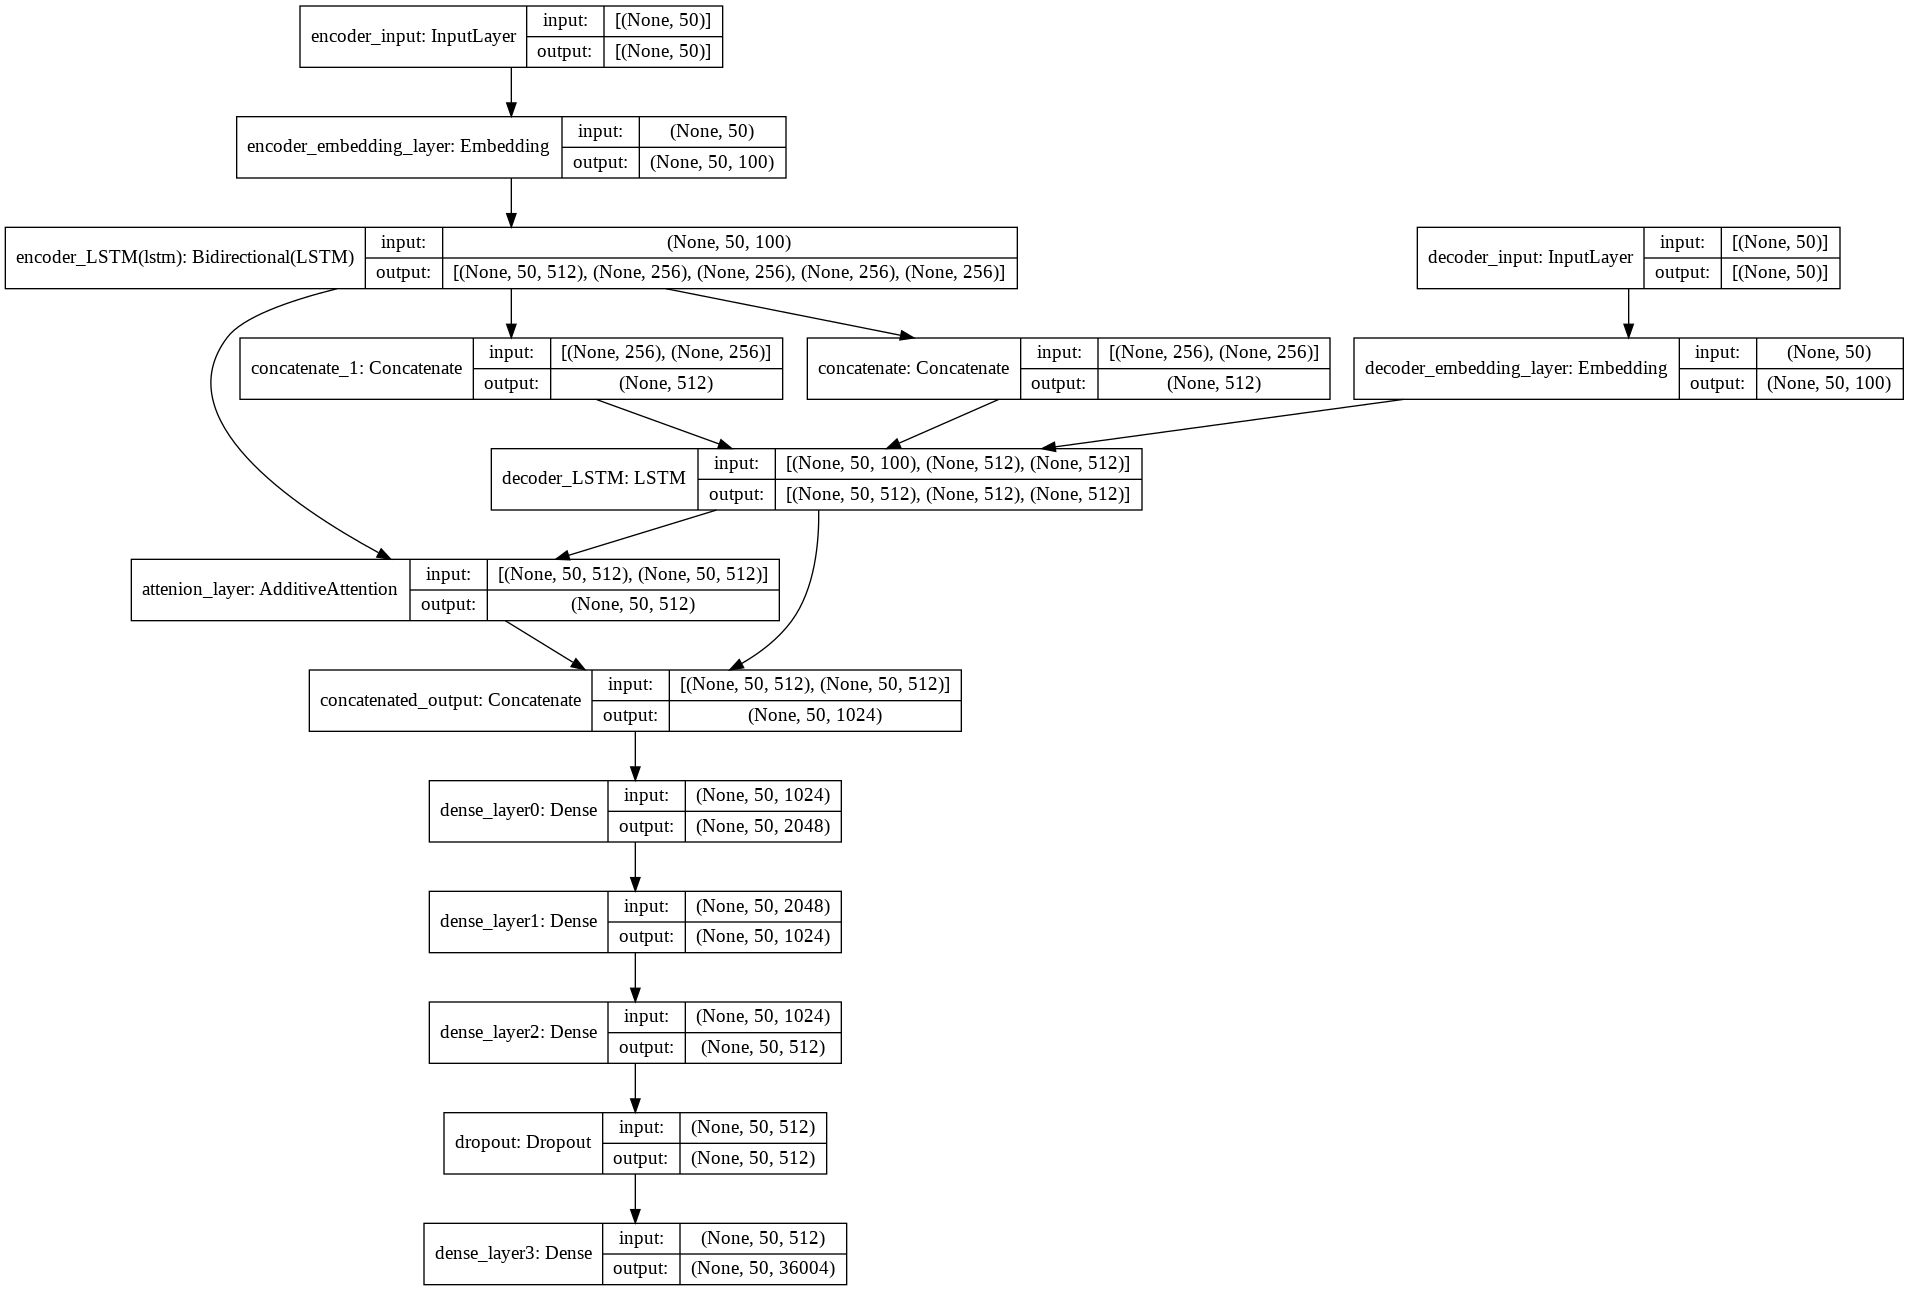

In [ ]:
print(model.summary())

model.compile(optimizer='rmsprop', loss ='sparse_categorical_crossentropy', metrics = [MaskedCategoricalAccuracy(empty_token_id_te),ExactMatchedAccuracy(empty_token_id_te)])

plot_model(model, to_file='model_with_Attention_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.load_weights("/content/model_attention (1).h5")

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=10, batch_size=64)
model.save_weights("model_bi_attention.h5")

Epoch 1/10
663/663 [==============================] - 907s 1s/step - loss: 1.7268 - accuracy: 0.8204
Epoch 2/10
663/663 [==============================] - 887s 1s/step - loss: 1.4444 - accuracy: 0.8306
Epoch 3/10
663/663 [==============================] - 886s 1s/step - loss: 1.2307 - accuracy: 0.8431
Epoch 4/10
663/663 [==============================] - 885s 1s/step - loss: 1.0070 - accuracy: 0.8600
Epoch 5/10
663/663 [==============================] - 884s 1s/step - loss: 0.8053 - accuracy: 0.8783
Epoch 6/10
663/663 [==============================] - 889s 1s/step - loss: 0.6541 - accuracy: 0.8955
Epoch 7/10
663/663 [==============================] - 896s 1s/step - loss: 0.4969 - accuracy: 0.9124
Epoch 8/10
663/663 [==============================] - 895s 1s/step - loss: 0.3455 - accuracy: 0.9308
Epoch 9/10
663/663 [==============================] - 898s 1s/step - loss: 0.2450 - accuracy: 0.9481
Epoch 10/10
663/663 [==============================] - 916s 1s/step - loss: 0.1905 - accura

In [ ]:
encoder_model = Model([encoder_input],[encoder_outputs,enc_state_h, enc_state_c])
encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
encoder_embedding_layer (Embedd (None, 50, 100)      4649900     encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_LSTM (Bidirectional)    [(None, 50, 512), (N 731136      encoder_embedding_layer[0][0]    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           encoder_LSTM[0][1]               
                                                                 encoder_LSTM[0][3]         

In [ ]:
input_h = Input(shape=(hidden_features * 2,),name='input_h')
input_c = Input(shape=(hidden_features * 2,),name='input_c')
encoder_output = Input(shape=(50, hidden_features * 2),name='encoder_output')

(decoder_output,output_h,output_c) = decoder_LSTM(decoder_embeddings,initial_state=[input_h, input_c])
attention_out = attention_layer([decoder_output, encoder_output])
concatenated_output = Concatenate()([decoder_output, attention_out])

de_la_0 = dense_layer0(concatenated_output)
de_la_1 = dense_layer1(de_la_0)
de_la_2 = dense_layer2(de_la_1)
dense_output = dense_layer3(de_la_2)

decoder_model = models.Model([encoder_output, decoder_input, input_h, input_c],[dense_output,output_h, output_c])
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
decoder_embedding_layer (Embedd (None, 50, 100)      3600400     decoder_input[0][0]              
__________________________________________________________________________________________________
input_h (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_c (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

In [ ]:
def translate(english_input):
    x_input=np.zeros((1,50) ,dtype=np.int32)
    cleaned_english_input=clean_text(english_input)
    splitted_english_input=cleaned_english_input.split()
    for i in range(50):
      if(i<len(splitted_english_input)):
        if(splitted_english_input[i] not in encoder_word_model.wv.vocab):
          x_input[0][i]=encoder_word_model.wv.vocab[unknown_word].index
        else:
          x_input[0][i]=encoder_word_model.wv.vocab[splitted_english_input[i]].index
      else:
        x_input[0][i]=encoder_word_model.wv.vocab[empty].index

    encoder_output,enc_state_h,enc_state_c = encoder_model.predict(x_input)

    telugu_seq = np.zeros((1, 50) ,dtype=np.int32)
    telugu_seq[0,0] = 0
    telugu_output = ""

    input_list = [{
        "decoder_input": {
                          "encoder_output": encoder_output,
                          "decoder_input": telugu_seq,
                          "input_h": enc_state_h,
                          "input_c": enc_state_c
        }}]

    for i in range(50):
      decoder_output, dec_state_h, dec_state_c = decoder_model.predict(input_list[0]["decoder_input"])

      indx=np.argmax(decoder_output[0,0,:])

      if (indx==1):
        break

      if (indx>0 and indx!=36034):
        telugu_output=telugu_output+" "+decoder_word_model.wv.index2word[indx]

      telugu_seq = np.zeros((1, 50) ,dtype=np.int32)
      telugu_seq[0,0] = indx

      enc_state_h = dec_state_h
      enc_state_c = dec_state_c

      input_list = [{
        "decoder_input": {
                          "encoder_output": encoder_output,
                          "decoder_input": telugu_seq,
                          "input_h": enc_state_h,
                          "input_c": enc_state_c
        }}]

    return telugu_output


In [ ]:
j=0
for i in range(len(encoder_docs)):
  print("ENGLISH -------------",encoder_docs[j])
  print("TELUGU---------------",translate(encoder_docs[j]))
  j=j+4
  print("")
  if(i==0):
    break

In [ ]:
text="Everyday without reading Bible and praying they do not start any work."
print("ENGLISH -------------",text)
print("TELUGU---------------",translate(text))


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
predicted_docs=[]
actual_docs=[]

for i in range(len(total_training_en)):
  if(len(clean_text(total_training_en[i]).split())>50):
    continue
  telugu=translate(total_training_en[i])

  predicted_docs.append(telugu.split())
  if(i<len(total_training_te_docs)):
    actual_docs.append(clean_text(total_training_te_docs[i]).split())

score=0
for sentence in predicted_docs:
  score = score +  sentence_bleu(actual_docs,sentence)

print(score/len(predicted_docs))

In [ ]:
print("BLEU SCORE FOR LSTM MODEL WITHOUT ATTENTION   ------>  ",score/len(predicted_docs))